In [1]:
import pymysql as pm
import pandas as pd
import numpy as np
from pymysql.constants import CLIENT
import os
from itertools import product

import jieba
import re
import time
from keras.preprocessing.text import Tokenizer
from sklearn.externals import joblib
from sklearn import ensemble
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score,auc,f1_score,recall_score,precision_score
from IPython.core.interactiveshell import InteractiveShell as IS
IS.ast_node_interactivity='all'
import warnings
warnings.filterwarnings('ignore')
import openpyxl 

Using TensorFlow backend.
E:\ANACONDA\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# 数据提取和处理

## 文本数据提取

In [2]:
def connect_sql(db='base_public'):
    '''连接数据库'''
    conn = pm.connect(host='db.chfdb.cc',
                            port=4171,
                            user='jr_19821215521',
                            password='$CwoBpibFNX9',
                            db=db,
                            charset='utf8mb4',
                            client_flag=CLIENT.MULTI_STATEMENTS,
                            cursorclass=pm.cursors.DictCursor)
    
    return conn

In [3]:
conn=connect_sql()
cs=conn.cursor()
sql_code='select * from fund_description'
count = cs.execute(sql_code)
result=cs.fetchall()
df_text=pd.DataFrame(result)
conn.close()
df_text=df_text.drop(columns=['entry_time','update_time','data_source'])

## 人工标注

In [4]:
conn=connect_sql()
cs=conn.cursor()
sql_code='SELECT * FROM fund_type_mapping'
count = cs.execute(sql_code)
result=cs.fetchall()
df_label=pd.DataFrame(result)
conn.close()
# 替换空值
none_nan=lambda value:value if value else np.nan
df_label=df_label.applymap(none_nan)
df_label=df_label[['fund_id','fund_name','type_code','type_name','stype_code','stype_name']]

## 两个维度的标签

In [5]:
df2=df_label[df_label['type_code'].str.startswith('02')]
df4=df_label[df_label['type_code'].str.startswith('04')]

## 数据变更

In [8]:
sql='''SELECT  fund_id,COUNT(DISTINCT fund_name) CT FROM `fund_announcement`
WHERE `type` = '发行运作'
GROUP BY fund_id
HAVING CT > 1'''
conn=connect_sql()
cs=conn.cursor()
count = cs.execute(sql)
result=cs.fetchall()
id_drop=pd.DataFrame(result)
conn.close()

## 完整基金名称

In [6]:
sql='''SELECT fund_id,fund_full_name FROM fund_info'''
conn=connect_sql()
cs=conn.cursor()
count = cs.execute(sql)
result=cs.fetchall()
full_name=pd.DataFrame(result)
conn.close()

## 合并数据集

In [9]:
prefix=pd.merge(df2[['fund_id','type_name','stype_name']],df4[['fund_id','type_name','stype_name']],left_on='fund_id',
        right_on='fund_id')
df=pd.merge(prefix,df_text,left_on='fund_id',right_on='fund_id',how='outer')
data=pd.merge(full_name,df,left_on='fund_id',right_on='fund_id')
data=data[~data['fund_id'].isin(id_drop['fund_id'].tolist())]
data.drop(columns=['fund_name','income_distribution','guarantee_institution','guarantee_period','guarantee_way'],inplace=True)
data.rename(columns={'fund_full_name':'fund_name'},inplace=True)
data=data.sort_values(by='type_name_x')
data=data.reset_index(drop=True)
data.to_excel('文本数据2.xlsx',index=False,encoding='utf-8-sig')

# 基金分类的说明（基于文本数据）

## 任务

In [36]:
# df.iloc[[0],:]

,fund_id,fund_name,type_name_x,stype_name_x,type_name_y,stype_name_y,investment_target,investment_scope,investment_strategy,investment_idea,risk_return_character,comparison_criterion,tracking_benchmark,type_pred_x,stype_pred_x,type_pred_y,stype_pred_y
0,005698,华夏全球科技先锋混合型证券投资基金(QDII),QDII基金,QDII混合型基金,主动型,主动型,在有效控制投资风险的前提下，通过积极主动的投资，力求实现基金资产的持续稳健增值。,本基金主要投资于境内市场和境外市场依法发行的金融工具，境内市场投资工具包括依法发行上市的股票...,1、资产配置策略本基金通过定性分析与定量分析相结合的方法分析宏观经济和资本市场发展趋势，采用...,NaN,本基金属于混合基金，风险与收益高于债券基金与货币市场基金，属于较高风险、较高收益的品种。本基...,中证TMT产业主题指数收益率*30%+中证中美TMT指数收益率*40%+上证国债指数收益率*30%,该基金无跟踪标的,QDII基金,QDII混合型基金,主动型,主动型


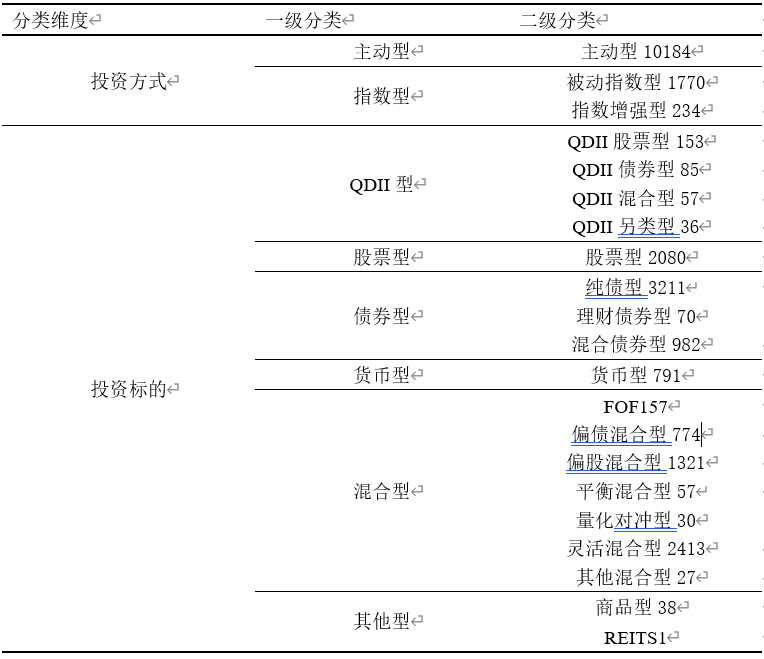

## 方法

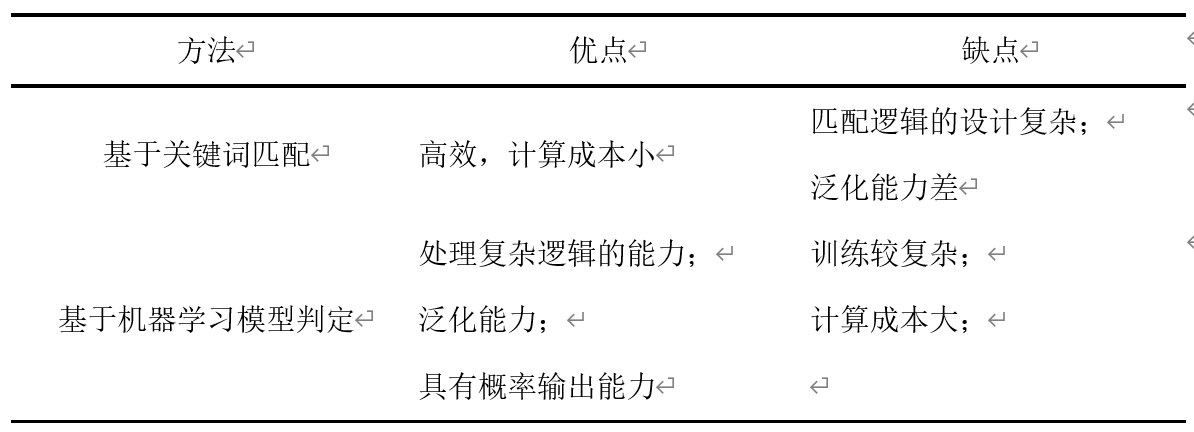

## 难点

1. 特征、字段设计（特征对的结果的影响较大）

2. 判别顺序设计（特征差异）

3. 判别逻辑设计（关键词类间尽可能独立，区分度尽可能高）

4. 样本量差异大，单一方法难完成


## 分类原则

1. 人工校核成本尽可能低（准确率尽可能高，判别率尽可能高）

2. 大样本采用机器学习判别，小样本利用关键词提取

3. 区分度低采用机器学习判别，区分度高利用关键词提取（逻辑复杂或模糊）

## 判别流程

1. 一级分类结果决定二级分类任务

2. 按照设定的提取顺序确定类别（提取段落包含某一类别的提取逻辑、提取字段）
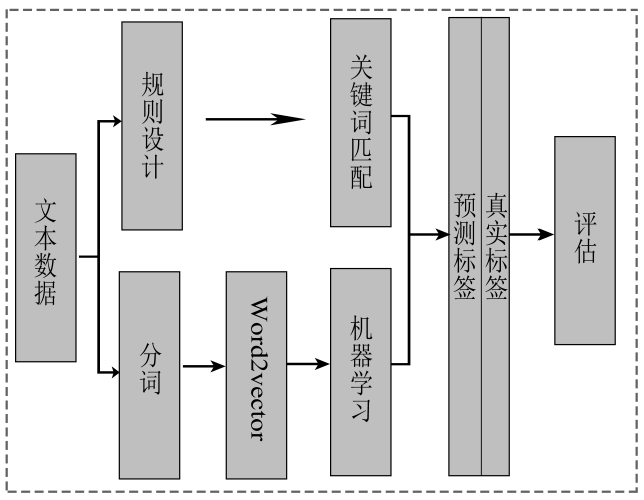

# 机器学习模型

In [2]:
def sample_generate(X_all,y_all,size,sd=100):
    '''生成平衡样本'''
    np.random.seed(sd)
    y_lst=np.unique(y_all)
    X_train_lst=[]
    X_test_lst=[]
    y_train_lst=[]
    y_test_lst=[]
    for i in y_lst:
        choice_idx=np.random.choice(np.arange((y_all==i).sum()),size=size,replace=False)
        notchoice_idx=pd.Index(np.arange((y_all==i).sum())).isin(choice_idx)
        X_train=X_all[y_all==i][choice_idx]
        X_test=X_all[y_all==i][~notchoice_idx]
        X_train_lst.append(X_train)
        X_test_lst.append(X_test)
        y_train_lst.extend([i]*len(X_train))
        y_test_lst.extend([i]*len(X_test))
        
    X=np.row_stack(X_train_lst)
    y=np.array(y_train_lst)
    X_test=np.row_stack(X_test_lst)
    y_test=np.array(y_test_lst)
    return (X,y),(X_test,y_test)

In [3]:
def confusion_matrix(y_true,y_pred,label_lst=None):
    '''评估指标'''
    from itertools import product
    if label_lst is None:
        label_lst=np.unique(y_true)
        
    matrix=np.zeros((len(label_lst),len(label_lst)),dtype=int)
    for row_label,col_label in product(range(len(label_lst)),range(len(label_lst))):
        matrix[row_label,col_label]=(y_pred[y_true==row_label]==col_label).sum()
    sample_num_lst=[]
    for i in range(len(label_lst)):
        sample_num_lst.append((y_true==i).sum())
    matrix=pd.DataFrame(matrix)
    matrix.index=zip(['y_true']*len(label_lst),label_lst,sample_num_lst)
    matrix.columns=zip(['y_pred']*len(label_lst),label_lst)

    if len(label_lst)>2:
        aver='weighted'
    else:
        aver='binary'
    indicator=pd.DataFrame([accuracy_score(y_true,y_pred),
    precision_score(y_true,y_pred,average=aver),
    recall_score(y_true,y_pred,average=aver),
    f1_score(y_true,y_pred,average=aver)],index=['Acc','Precision','Recall','F1'],columns=['Indicator'])
    return [matrix,indicator]

## 分词模块

In [4]:
# 根据词库分词
jieba.load_userdict("70000-dict.txt")
def divide_word(string):
    try:
        seg_list = jieba.cut(string, cut_all=False)
        return " ".join(seg_list)
    except:
        return " "
segment=lambda content:[divide_word(i) for i in content]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\RUBYEE~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.654 seconds.
Prefix dict has been built successfully.


## 词向量库

In [5]:
%%time
embeddings_index = {}
# key 为词，value为向量表示
with open('sgns.financial.bigram','r',encoding='UTF-8') as f:
    for i,line in enumerate(f):
        if i == 0:
            continue
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))
EMBEDDING_DIM = coefs.shape[0]

Found 467128 word vectors.
Wall time: 44 s


## word2vec
从词向量库提取向量对应content的词向量库


word_index是content的词库，字典形式，key:字符value:序号,1开始

embedding_index是词向量库，字典形式，key:字符,value:词向量

embedding_matrix是content对应后的词向量库

word_vector是content的词向量库，key:序号1开始,value:向量


之所以用序号做key，是因为sequence已被转化为序号的集合

In [6]:
def word2vec(texts,embeddings_index,EMBEDDING_DIM):
    # 将texts中出现过的词组成词库word_index
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # 词库：字典，序号从1开始
    word_index = tokenizer.word_index
    # print('Found %s unique tokens.' % len(word_index))
    
    embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i-1] = embedding_vector
    word_vector=dict(zip(np.arange(1,embedding_matrix.shape[0]+1),embedding_matrix))
    
    # 将每个content包含的词向量取均值
    content_vector=np.zeros((len(sequences),EMBEDDING_DIM))
    for i,sequence_i in enumerate(sequences):
        _vector_array=np.zeros(EMBEDDING_DIM)
        # sequence_i 表示一个content
        for j in sequence_i:
            # j 为每个content包含的序号
            _vector=word_vector.get(j)
            if _vector is not None:
                _vector_array+=_vector
        content_vector[i]=_vector_array/len(sequence_i)
    return content_vector

In [7]:
def word2vec_for_bond(texts,embeddings_index,EMBEDDING_DIM,coef_up):
    # 将texts中出现过的词组成词库word_index
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    # 词库：字典，序号从1开始
    word_index = tokenizer.word_index

    np.random.seed(125)
    _embeddings_index=embeddings_index.copy()
    
    # 为所有分词赋向量
    embedding_matrix = np.zeros((len(word_index), EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = _embeddings_index.get(word)
        if embedding_vector is None:
            _embeddings_index[word]=np.random.randn(300)
        embedding_matrix[i-1] = _embeddings_index.get(word)
        
    word_vector=dict(zip(np.arange(1,embedding_matrix.shape[0]+1),embedding_matrix))
    # 小于100的值在字典中的ID
    idx_lst=[]
    for key,value in word_index.items():
        if key.isnumeric():
            if int(key)<100 and key!='00':
                idx_lst.append(value)

    # 将每个content包含的词向量取均值
    content_vector=np.zeros((len(sequences),EMBEDDING_DIM))
    for i,sequence_i in enumerate(sequences):
        # 该句包含的数字的ID
        num_dic_idx=np.array(sequence_i)[pd.Index(sequence_i).isin(idx_lst)]
        if len(num_dic_idx)!=0:
            # 反解出该句的数字
            biggest_num_lst=[int(list(word_index.keys())[list(word_index.values()).index(_num_idx)]) for _num_idx in num_dic_idx]
#             if max(biggest_num_lst)>65:
            # 得到最大的数字的ID
            biggest_num_idx=word_index.get(str(max(biggest_num_lst)))
            # 该句中数字的索引
            num_idx_lst=[np.where(np.array(sequence_i)==j)[0][0]+1 for j in num_dic_idx]
            # 最大数字的区块
            partion_idx=np.where(num_dic_idx==biggest_num_idx)[0][0]
            # 将句子按照数字区分
            split_sequence=np.split(sequence_i,num_idx_lst)

            _vector_array=np.zeros(EMBEDDING_DIM)
            for j in range(len(split_sequence)):
                if j==partion_idx:
                    for z in split_sequence[j]:
                        _vector_array+=word_vector.get(z)*coef_up
                if j!=partion_idx:
                    for z in split_sequence[j]:
                        _vector_array+=word_vector.get(z)
            content_vector[i]=_vector_array/len(sequence_i)

        if len(num_dic_idx)==0:
            _vector_array=np.zeros(EMBEDDING_DIM)
            for z in sequence_i:
                _vector_array+=word_vector.get(z)
            content_vector[i]=_vector_array/len(sequence_i)
    return content_vector

# 投资标的判别

## 一级判别

In [8]:
def _basic_classification(string,pattern,dic):
    try:
        # 防止空值
        _=re.findall(pattern,string)
    except:
        return False
    if len(_)>0:
        if dic.get(_[0]) is None:
            return True
        else:
            return dic.get(_[0])
    else:
        return False
    
def basic_classification(df,**kwds):
    dic=kwds.get('dic')
    pattern=kwds.get('pattern_name')
    if  pattern is not None:
        con1=df['fund_name'].apply(_basic_classification,dic=dic,pattern=pattern)
    else:
        con1=np.array([False]*len(df))
        
    pattern=kwds.get('pattern_risk')
    if pattern is not None:
        con2=df['risk_return_character'].apply(_basic_classification,dic=dic,pattern=pattern)
    else:
        con2=np.array([False]*len(df))
        
    pattern=kwds.get('pattern_benchmark')
    if pattern is not None:
        con3=df['tracking_benchmark'].apply(_basic_classification,dic=dic,pattern=pattern)
    else:
        con3=np.array([False]*len(df))
        
    pattern=kwds.get('pattern_criter')
    if pattern is not None:
        con4=df['comparison_criterion'].apply(_basic_classification,dic=dic,pattern=pattern)
    else:
        con4=np.array([False]*len(df))
        
    pattern=kwds.get('pattern_strategy')
    if pattern is not None:
        con5=df['investment_strategy'].apply(_basic_classification,dic=dic,pattern=pattern)
    else:
        con5=np.array([False]*len(df))

    pattern=kwds.get('pattern_target')
    if pattern is not None:
        con6=df['investment_target'].apply(_basic_classification,dic=dic,pattern=pattern)
    else:
        con6=np.array([False]*len(df))
        
    condition=con1|con2|con3|con4|con5|con6
    return condition


In [9]:
def re_four_classification(string,**kwds):
    try:
        # 分句
        split_string=np.array(re.split('[，,.;。]',string ))
    except:
        return 999
    pattern_th=kwds.get('pattern_th')
    pattern_name=kwds.get('pattern_name')
    dic=kwds.get('dic')
    if '属'  in split_string[0] or '是' in split_string[0] or '为' in split_string[0]:
        _a=re.findall(pattern_name,split_string[0])
        if len(_a)==1:
            result = dic.get(_a[0])
            return result
    # 存在高于或低于
    contain_th=np.array([len(re.findall(pattern_th,i))>0 for i in split_string])
    if contain_th.sum()!=0:
        # 合并包含相邻高于或低于的句子
        position_lst=np.where(contain_th==1)[0]
        position=[]
        for i in range(len(position_lst)-1):
            if position_lst[i]+1==position_lst[i+1]:
                position=[position_lst[i],position_lst[i+1]]
        if len(position)==2:
            _string=','.join(split_string[position])
        if len(position)!=2:
            _string=','.join(split_string[contain_th])
        # 提取类型
        _a=re.findall(pattern_name,_string)
        type_lst=np.arange(4)
        result=type_lst[~pd.Index(type_lst).isin(pd.Series(_a).map(dic).values.tolist())]
        if len(result)==1:
            # 恰好逼近
            return result[0]
        if len(result)==0:
            # 没有额外类型
            return 999
        if len(result)>1:
            # 选择范围大
            return 999
    else:
        return 999

In [10]:
def match_classification(string,pattern):
    try:
        # 分句
        split_string=np.array(re.split('[，,.;。]',string ))
    except:
        return False
    for _string in split_string:
        _=re.findall(pattern,_string)
        if len(_)>0:
            return True
    return False

### 关键词匹配判别(QDII,其他)

In [11]:
def primary_QDII(df):
    # QDII
    pattern_name=re.compile('QDII|港美|亚洲|海外|亚太|美国|美元|美汇|美钞|境外|道琼斯|标普|纳斯达克|日经')
    pattern_risk=re.compile('QDII|海外|国外|新兴市场|港美|印度|亚太|美国|新加坡|国际')
    pattern_benchmark=re.compile('香港恒生|恒生中国|法兰克福')
    qdii_condition1=basic_classification(df,dic={},pattern_name=pattern_name,pattern_risk=pattern_risk,pattern_benchmark=pattern_benchmark)

    pattern_scope=re.compile('(投资于|投资范围).*(大中华|美国|国外|外汇|新兴市场|印度|新兴市场|港美|亚洲|海外|亚太|新加坡|美元|美汇|美钞|境外|道琼斯|标普|纳斯达克|日经)')
    qdii_condition2=df['combined'].apply(match_classification,pattern=pattern_scope)
    pattern_scope=re.compile('谅解备忘录')
    qdii_condition3=basic_classification(df,pattern_scope=pattern_scope,dic={})
    df['type_pred_x'][qdii_condition1|qdii_condition2|qdii_condition3]=5
    return df
def primary_QITA(df):
    # 其他
    df_removed=df[df['type_pred_x']==999]
    pattern_risk=re.compile('黄金|原油|白银|饲料|有色金属|商品期货|REIT|房地产|商品类')
    qita_condition=basic_classification(df_removed,dic={},pattern_risk=pattern_risk)
    idx=df_removed.index[qita_condition]
    df['type_pred_x'].iloc[idx]=4
    return df
category_label_dic={'股票基金':2,'股票型基金':2,'股票型':2,'债券基金':0,'债券型基金':0,'债券型':0,
      '货币市场基金':3,'货币市场型':3,'货币型':3,'货币型基金':3,'混合基金':1,
      '混合型基金':1,'混合型':1,'其他基金':4}
def primary_four_a(df):
    # 四分类首先按照fund_name
    df_removed=df[df['type_pred_x']==999]
    pattern_name=re.compile('(混合型|债券型|股票型|货币型)')
    y_pred=df_removed['fund_name'].apply(_basic_classification,pattern=pattern_name,dic=category_label_dic)
    y_pred[y_pred==False]=999
    df['type_pred_x'][df['type_pred_x']==999]=y_pred

    # 四分类其次按照risk_return_character
    df_removed=df[df['type_pred_x']==999]
    pattern1=re.compile('(高于|低于)')
    pattern2=re.compile('(混合基金|混合型基金|混合型|债券型|债券基金|债券型基金|股票基金|股票型基金|股票型|货币市场基金|货币市场型|货币型|货币型基金)')
    y_pred=df_removed['risk_return_character'].apply(re_four_classification,pattern_th=pattern1,pattern_name=pattern2,dic=category_label_dic)
    df['type_pred_x'][df['type_pred_x']==999]=y_pred
    return df

### 模型训练(四分类)

In [12]:
def primary_four_b_train(df):
    # 四分类最后利用模型判断
    df_removed=df[(df['type_pred_x']!=4) & (df['type_pred_x']!=5) &(df['type_pred_x']!=999)]
    df_feature=df_removed[['fund_name','risk_return_character']]
    df_feature=df_feature.astype(str).values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec(texts,embeddings_index,EMBEDDING_DIM)

    y_all=df_removed['type_pred_x'].astype(int)
    size,seed=int(y_all.value_counts().min()/100)*100,200
    (X,y),(X_test,y_test)=sample_generate(content_vetor,y_all,size,seed)
    # 降维，并指定二分类或多分类
    pca=PCA(n_components=50)
    X=pca.fit_transform(X)
    print('投资标的四分类PCA方差占比%f'%pca.explained_variance_ratio_.sum())

    model=ensemble.ExtraTreesClassifier()
    model_fit=model.fit(X,y)
    joblib.dump(model, 'four_classification.model')
    joblib.dump(pca,'four_classfication.pca')
    y_pred=model.predict(pca.transform(X_test))
    con_matrix=confusion_matrix(y_test,y_pred)[0]
    con_indicator=confusion_matrix(y_test,y_pred)[1]
    print('投资标的四分类模型训练完成')
    return con_matrix,con_indicator

### 模型预测(四分类)

In [13]:
def primary_four_b_predict(df):
    df_removed=df[df['type_pred_x']==999]
    df_feature=df_removed[['fund_name','risk_return_character']]
    df_feature=df_feature.astype(str).values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec(texts,embeddings_index,EMBEDDING_DIM)

    # 降维，并指定二分类或多分类
    pca=joblib.load('four_classfication.pca')
    model = joblib.load('four_classification.model')
    X_val=pca.transform(content_vetor)
    y_pred=model.predict(X_val)

    y_pred_prob=model.predict_proba(X_val)
    prob=np.array([y_pred_prob[i][np.argmax(y_pred_prob,axis=1)[i]] for i in range(len(y_pred_prob))])
    # probality_lower=0.5
    # idx=df_removed.index[prob>=probality_lower]
    # df['type_pred_x'].iloc[idx]=y_pred[prob>=probality_lower]
    idx=df_removed.index
    df['type_pred_x'].iloc[idx]=y_pred
    df['type_pred_prob_x'].iloc[idx]=prob
    return df

In [14]:
def primary_name(df):
    df['type_pred_x'][df['type_pred_x']==0]='债券型基金'
    df['type_pred_x'][df['type_pred_x']==1]='混合型基金'
    df['type_pred_x'][df['type_pred_x']==2]='股票型基金'
    df['type_pred_x'][df['type_pred_x']==3]='货币型基金'
    df['type_pred_x'][df['type_pred_x']==4]='其他基金'
    df['type_pred_x'][df['type_pred_x']==5]='QDII基金'
    return df

## 二级分类

### 货币型,股票型,其他型

In [15]:
def secondary_name(df):
    df['stype_pred_x'][df['type_pred_x']=='股票型基金']='股票型'
    df['stype_pred_x'][df['type_pred_x']=='货币型基金']='货币型'
    df['stype_pred_x'][df['type_pred_x']=='其他基金']='商品型基金'
    return df

### 关键词匹配(QDII,理财债券型)

In [16]:
def secondary_QDII(df):
    # QDII二级分类
    df_qdii=df[(df['type_pred_x']=='QDII基金')]
    pattern1=re.compile('(高于|低于)')
    pattern2=re.compile('(混合基金|混合型基金|混合型|债券型|债券基金|债券型基金|股票基金|股票型基金|股票型|货币市场基金|货币市场型|货币型|货币型基金)')
    y_pred=df_qdii['risk_return_character'].apply(re_four_classification,pattern_th=pattern1,pattern_name=pattern2,dic=category_label_dic)
    qdii_dic={0:'QDII债券型基金',1:'QDII混合型基金',2:'QDII股票型基金'}
    df['stype_pred_x'].iloc[y_pred.index]=pd.Series(y_pred).apply(lambda x:qdii_dic.get(x,999)).values

    # 另类
    df_removed=df_qdii[y_pred==999]
    pattern_risk=re.compile('黄金|原油|白银|饲料|有色金属|商品期货|REIT|房地产|商品类')
    con1=df_removed['risk_return_character'].apply(_basic_classification,pattern=pattern_risk,dic={})
    pattern_scope=re.compile('黄金|原油|白银|饲料|有色金属|商品期货|REIT|房地产|商品类')
    con2=df_removed['investment_scope'].apply(_basic_classification,pattern=pattern_risk,dic={})
    df['stype_pred_x'].iloc[df_removed.index[con1|con2]]='QDII另类投资基金'
    return df
def secondary_bond_a(df):
    # 债券型二级分类(fund_name,investment_scope)
    ## 首先提取出理财债券型
    df_bond=df[(df['type_pred_x']=='债券型基金')]
    pattern=re.compile('(理财).*(债券)')
    condition=df_bond['fund_name'].apply(_basic_classification,pattern=pattern,dic={})
    idx=df_bond.index[condition]
    df['stype_pred_x'].iloc[idx]='理财债券型'
    return df

### 模型训练(债券型)

In [17]:
def secondary_bond_b_train(df):
    df_removed=df[(df['type_pred_x']=='债券型基金')&(df['stype_pred_x']!='理财债券型')]
    df_feature=df_removed[['fund_name','investment_scope']]

    df_feature=df_feature.astype(str).values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec(texts,embeddings_index,EMBEDDING_DIM)

    certain_type=(df_removed['stype_name_x']=='纯债型')|(df_removed['stype_name_x']=='混合债券型')
    y_all=LabelEncoder().fit_transform(df_removed['stype_name_x'][certain_type])

    size,seed=int(pd.Series(y_all).value_counts().min()/100)*100,200
    (X,y),(X_test,y_test)=sample_generate(content_vetor[certain_type],y_all,size,seed)
    pca=PCA(n_components=50)
    X=pca.fit_transform(X)
    print('债券型PCA方差占比%f'%pca.explained_variance_ratio_.sum())

    model=ensemble.ExtraTreesClassifier()
    model_fit=model.fit(X,y)
    joblib.dump(model,'bond.model')
    joblib.dump(pca,'bond.pca')
    con_matrix=confusion_matrix(y_test,model.predict(pca.transform(X_test)))[0]
    con_indicator=confusion_matrix(y_test,model.predict(pca.transform(X_test)))[1]
    print('债券型模型训练完成')
    return con_matrix,con_indicator

### 模型预测(债券型)

In [18]:
def secondary_bond_b_predict(df):
    df_removed=df[(df['type_pred_x']=='债券型基金')&(df['stype_pred_x']!='理财债券型')]
    df_feature=df_removed[['fund_name','investment_scope']]

    df_feature=df_feature.astype(str).values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec(texts,embeddings_index,EMBEDDING_DIM)

    pca=joblib.load('bond.pca')
    model = joblib.load('bond.model')
    X_all=pca.transform(content_vetor)
    y_pred=model.predict(X_all)
    y_pred_prob=model.predict_proba(X_all)
    bond_dic={0:'混合债券型',1:'纯债型'}
    prob=np.array([y_pred_prob[i][np.argmax(y_pred_prob,axis=1)[i]] for i in range(len(y_pred_prob))])
    # probality_lower=0.6
    # idx=df_removed.index[prob>probality_lower]
    # df['stype_pred_x'].iloc[idx]=pd.Series(y_pred[prob>probality_lower]).map(bond_dic).values
    idx=df_removed.index
    df['stype_pred_x'].iloc[idx]=pd.Series(y_pred).map(bond_dic).values
    df['stype_pred_prob_x'].iloc[idx]=prob
    return df

### 关键词匹配(混合型-(FOF,量化对冲型,灵活配置型,部分偏债))

In [19]:
def balance_mix(string):
    try:
        string_lst=re.findall(r"\d\d+",string)
        if len(string_lst)!=0:
            try:
                is_threshold=np.array([int(i)<60 for i in string_lst])
                if len(is_threshold)==2:
                    return sum(is_threshold)==len(is_threshold)
                else:
                    return False
            except:
                return False
        else:
            return False
    except:
        return False

In [20]:
def secondary_mix_a(df):
    # FOF
    df_removed=df[df['type_pred_x']=='混合型基金']
    pattern_fof=re.compile('(属|为|是).*(FOF|基金中基金)')
    condition1=df_removed['combined'].apply(match_classification,pattern=pattern_fof)
    pattern_fof=re.compile('(FOF|基金中基金)')
    condition2=df_removed['fund_name'].apply(_basic_classification,pattern=pattern_fof,dic={})
    condition=condition1 | condition2
    df['stype_pred_x'].iloc[df_removed.index[condition]]='FOF'

    # 量化对冲型
    df_removed=df[(df['type_pred_x']=='混合型基金')&(df['stype_pred_x']!='FOF')]
    pattern_risk=re.compile('特殊的混合|特殊类型|绝对收益|量化对冲')
    pattern_name=re.compile('量化对冲|绝对收益')
    condition=basic_classification(df_removed,pattern_risk=pattern_risk,pattern_name=pattern_name,dic={})
    df['stype_pred_x'].iloc[df_removed.index[condition]]='量化对冲型'

    # 灵活配置型
    df_removed=df[(df['type_pred_x']=='混合型基金')&(df['stype_pred_x']!='FOF')&(df['stype_pred_x']!='量化对冲型')]
    pattern_name=re.compile('灵活配置')
    condition=basic_classification(df_removed,pattern_name=pattern_name,dic={})
    df['stype_pred_x'].iloc[df_removed.index[condition]]='灵活配置型'

    # 平衡混合型
    df_removed=df[(df['type_pred_x']=='混合型基金')&(df['stype_pred_x']!='FOF')&(df['stype_pred_x']!='量化对冲型')&(df['stype_pred_x']!='灵活配置型')]
    condition=df_removed['comparison_criterion'].apply(balance_mix)
    df['stype_pred_x'].iloc[df_removed.index[condition]]='平衡混合型'

    # 偏股偏债中的部分偏债
    df_removed=df[(df['type_pred_x']=='混合型基金')&(df['stype_pred_x']!='FOF')&(df['stype_pred_x']!='量化对冲型')&(df['stype_pred_x']!='灵活配置型')&(df['stype_pred_x']!='平衡混合型')]
    pattern1=re.compile('指数')
    condition1=~basic_classification(df_removed,pattern_criter=pattern1,dic={})
    pattern2=re.compile('银行')
    condition2=basic_classification(df_removed,pattern_criter=pattern2,dic={})
    condition=condition1&condition2
    df['stype_pred_x'].iloc[df_removed.index[condition]]='偏债混合型'
    return df

### 模型训练(偏债偏股)

In [21]:
def reconduct_string(string):
    if string is not None:
        if string[0].isnumeric():
            split_string=np.array(re.split('[*×+Xx]',string )).tolist()
            if len(split_string)%2==0:
                string_lst=[split_string[i+1]+'×'+split_string[i] for i in range(len(split_string))[::2]]
                re_string='+'.join(string_lst)
                return re_string
            else:
                return string
        else:
            return string
    else:
        return string

In [22]:
def secondary_mix_b_train(df,coef_up=2):
    df_removed=df[(df['type_pred_x']=='混合型基金')&(df['stype_pred_x']!='FOF')&(df['stype_pred_x']!='量化对冲型')&(df['stype_pred_x']!='灵活配置型')&(df['stype_pred_x']!='偏债混合型')&(df['stype_pred_x']!='平衡混合型')]
    df_feature=df_removed[['comparison_criterion']].astype(str).applymap(reconduct_string)

    df_feature=df_feature.values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec_for_bond(texts,embeddings_index,EMBEDDING_DIM,coef_up)

    certain_type=(df_removed['stype_name_x']=='偏债混合型')|(df_removed['stype_name_x']=='偏股混合型')
    y_all=LabelEncoder().fit_transform(df_removed['stype_name_x'][certain_type])

    size,seed=int(pd.Series(y_all).value_counts().min()/100-1)*100,200
    (X,y),(X_test,y_test)=sample_generate(content_vetor[certain_type],y_all,size,seed)
    pca=PCA(n_components=50)
    X=pca.fit_transform(X)
    print('偏债偏股PCA方差占比%f'%pca.explained_variance_ratio_.sum())
    model=ensemble.ExtraTreesClassifier()
    model_fit=model.fit(X,y)
    joblib.dump(model,'stock_bond.model')
    joblib.dump(pca,'stock_bond.pca')
    con_matrix=confusion_matrix(y_test,model.predict(pca.transform(X_test)))[0]
    con_indicator=confusion_matrix(y_test,model.predict(pca.transform(X_test)))[1]
    print('偏债偏股模型训练完成')
    return con_matrix,con_indicator

### 模型预测(偏债偏股)

In [23]:
def secondary_mix_b_predict(df,coef_up=2):
    df_removed=df[(df['type_pred_x']=='混合型基金')&(df['stype_pred_x']!='FOF')&(df['stype_pred_x']!='量化对冲型')&(df['stype_pred_x']!='灵活配置型')&(df['stype_pred_x']!='偏债混合型')&(df['stype_pred_x']!='平衡混合型')]
    df_feature=df_removed[['comparison_criterion']].astype(str).applymap(reconduct_string)

    df_feature=df_feature.values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec_for_bond(texts,embeddings_index,EMBEDDING_DIM,coef_up)

    pca=joblib.load('stock_bond.pca')
    model = joblib.load('stock_bond.model')
    X_all=pca.transform(content_vetor)
    y_pred=model.predict(X_all)
    y_pred_prob=model.predict_proba(X_all)
    mix_dic={0:'偏债混合型',1:'偏股混合型'}
    prob=np.array([y_pred_prob[i][np.argmax(y_pred_prob,axis=1)[i]] for i in range(len(y_pred_prob))])
    # probality_lower=0.6
    # idx=df_removed.index[prob>probality_lower]
    # df['stype_pred_x'].iloc[idx]=pd.Series(y_pred[prob>probality_lower]).map(mix_dic).values
    idx=df_removed.index
    df['stype_pred_x'].iloc[idx]=pd.Series(y_pred).map(mix_dic).values
    df['stype_pred_prob_x'].iloc[idx]=prob
    return df

# 投资方式分类

## 投资方式一级

### 模型训练(二分类)

In [24]:
def primary_two_train(df):
    # 合成特征文本
    df_removed=df[['fund_name','investment_target','investment_strategy','comparison_criterion','tracking_benchmark']]
    df_removed['investment_strategy']=df_removed['investment_strategy'].str.split('。').str[0]
    df_feature=df_removed.astype(str).values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec(texts,embeddings_index,EMBEDDING_DIM)

    y_all=LabelEncoder().fit_transform(df['type_name_y'])

    # 降维，并指定二分类或多分类
    size,seed=(int(pd.Series(y_all).value_counts().min()/100)-3)*100,200
    (X,y),(X_test,y_test)=sample_generate(content_vetor,y_all,size,seed)
    pca=PCA(n_components=100)
    X=pca.fit_transform(X)
    print('投资方式二分类PCA方差占比%f'%pca.explained_variance_ratio_.sum())
    model=ensemble.ExtraTreesClassifier()
    model_fit=model.fit(X,y)
    joblib.dump(model,'investment_way1.model')
    joblib.dump(pca,'investment_way1.pca')
    con_matrix=confusion_matrix(y_test,model.predict(pca.transform(X_test)))[0]
    con_indicator=confusion_matrix(y_test,model.predict(pca.transform(X_test)))[1]
    print('投资方式二分类模型训练完成')
    return con_matrix,con_indicator

### 模型预测(二分类)

In [25]:
def primary_two_predict(df):
    # 合成特征文本
    df_removed=df[['fund_name','investment_target','investment_strategy','comparison_criterion','tracking_benchmark']]
    df_removed['investment_strategy']=df_removed['investment_strategy'].str.split('。').str[0]
    df_feature=df_removed.astype(str).values.tolist()
    content=['，'.join(i) for i in df_feature]
    texts=segment(content)
    content_vetor=word2vec(texts,embeddings_index,EMBEDDING_DIM)

    pca=joblib.load('investment_way1.pca')
    model = joblib.load('investment_way1.model')
    X_all=pca.transform(content_vetor)
    y_pred=model.predict(X_all)
    y_pred_prob=model.predict_proba(X_all)
    investmentway_dic={0:'主动型',1:'指数型'}
    prob=np.array([y_pred_prob[i][np.argmax(y_pred_prob,axis=1)[i]] for i in range(len(y_pred_prob))])
    # probality_lower=0.6
    # idx=df_removed.index[prob>probality_lower]
    # df['type_pred_y'].iloc[idx]=pd.Series(y_pred[prob>probality_lower]).map(investmentway_dic).values
    idx=df_removed.index
    df['type_pred_y'].iloc[idx]=pd.Series(y_pred).map(investmentway_dic).values
    df['type_pred_prob_y'].iloc[idx]=prob
    return df

## 投资方式二级

In [26]:
def secondary_pos(df):
    df['stype_pred_y'][df['type_pred_y']=='主动型']='主动型'
    return df

In [27]:
def secondary_non_pos(df):
    df_removed=df[df['type_pred_y']=='指数型']
    pattern_risk=re.compile('(为|属|是).*(增强)')
    condition1=df_removed['combined'].apply(match_classification,pattern=pattern_risk)

    pattern_strategy=re.compile('(增强).*(优化)')
    condition2=df_removed['combined'].apply(match_classification,pattern=pattern_strategy)

    pattern_name=re.compile('指增|指数增强|增强')
    pattern_strategy=re.compile('(指数增强)')
    condition3=basic_classification(df_removed,pattern_name=pattern_name,pattern_strategy=pattern_strategy,dic={})

    condition=condition1|condition2|condition3
    df['stype_pred_y'].iloc[df_removed.index[condition]]='指数增强型'
    df['stype_pred_y'].iloc[df_removed.index[~condition]]='被动指数型'
    return df

# 分类任务合并

In [28]:
def TARGET_classification(df,coef_up=2,primary_four_train=False,secondary_bond_train=False,secondary_mix_train=False):
    lst=[]
    try:
        # 一级
        df=primary_QDII(df)
        df=primary_QITA(df)
        df=primary_four_a(df)
        if primary_four_train:
            con_matrix,con_indicator=primary_four_b_train(df)
            lst.append(con_matrix)
            lst.append(con_indicator)
        df=primary_four_b_predict(df)
        df=primary_name(df)
        # 二级
        df=secondary_name(df)
        df=secondary_QDII(df)
        df=secondary_bond_a(df)
        if secondary_bond_train:
            con_matrix,con_indicator=secondary_bond_b_train(df)
            lst.append(con_matrix)
            lst.append(con_indicator)
        df=secondary_bond_b_predict(df)
        df=secondary_mix_a(df)
        if secondary_mix_train:
            con_matrix,con_indicator=secondary_mix_b_train(df,coef_up)
            lst.append(con_matrix)
            lst.append(con_indicator)
        df=secondary_mix_b_predict(df,coef_up)
    except:
        return df,lst
    return df,lst

In [29]:
def WAY_classification(df,primary_train=False):
    lst=[]
    try:
        if primary_train:
            con_matrix,con_indicator=primary_two_train(df)
            lst.append(con_matrix)
            lst.append(con_indicator)
        df=primary_two_predict(df)
        df=secondary_pos(df)
        df=secondary_non_pos(df)
    except:
        return df,lst
    return df,lst

# 实验结果

In [30]:
def input_data_process(df):
    assert df.shape[0]>0,'输入数据为空'
    
    df_combined=df[['fund_name','investment_target', 'investment_scope','investment_strategy', 'investment_idea', 
       'risk_return_character','comparison_criterion', 'tracking_benchmark']].astype(str).values
    df['combined']=[','.join(i) for i in df_combined]
    df['type_pred_x'],df['stype_pred_x']=999,999
    df['type_pred_prob_x']=np.random.randint(7000,10000,size=df.shape[0])/10000
    df['stype_pred_prob_x']=np.random.randint(7000,10000,size=df.shape[0])/10000

    df['type_pred_y'],df['stype_pred_y']=999,999
    df['type_pred_prob_y']=np.random.randint(7000,10000,size=df.shape[0])/10000
    df['stype_pred_prob_y']=np.random.randint(7000,10000,size=df.shape[0])/10000
    df=df.reset_index(drop=True)
    return df

In [31]:
def output_data_process(df,file_name=None,save=True,primary_four_threshold=0.5,
                    secondary_mix_threshold=0.6,
                    secondary_bond_threshold=0.6,
                    primary_two_threshold=0.6):
    df=df.drop(columns=['combined'])
    drop_lst=[]
    try:
        idx=df.index[(df['type_pred_x']==999)|(df['stype_pred_x']==999)]
        drop_lst.extend(idx)

        df_removed=df[(df['type_pred_x']!='其他基金') & (df['type_pred_x']!='QDII基金')]
        idx=df_removed.index[df_removed['type_pred_prob_x']<=primary_four_threshold]
        drop_lst.extend(idx)

        df_removed=df[(df['type_pred_x']=='债券型基金')&(df['stype_pred_x']!='理财债券型')]
        idx=df_removed.index[df_removed['stype_pred_prob_x']<=secondary_bond_threshold]
        drop_lst.extend(idx)

        df_removed=df[(df['stype_pred_x']=='偏债混合型')|(df['stype_pred_x']=='偏股混合型')]
        idx=df_removed.index[df_removed['stype_pred_prob_x']<=secondary_mix_threshold]
        drop_lst.extend(idx)
    except:
        pass
    try:
        idx=df.index[(df['type_pred_y']==999)|(df['stype_pred_y']==999)]
        drop_lst.extend(idx)

        idx=df.index[df['type_pred_prob_y']<=primary_two_threshold]
        drop_lst.extend(idx)
    except:
        pass
    drop_lst=list(set(drop_lst))
    df_pred=df.drop(index=drop_lst)
    df_revised=df.iloc[drop_lst]
    if save:
        path=_write_excel(df,file_name,sheet_name='所有预测结果')
        path=_write_excel(df_pred,file_name,sheet_name='高概率预测结果')
        path=_write_excel(df_revised,file_name,sheet_name='低概率预测结果')
    return df,df_pred,df_revised

In [32]:
def _write_excel(df,file_name,sheet_name):
    '''写入数据，默认路径为当前脚本所在位置。
    
    :df: 数据框。
    :file_name: 文件名。
    :sheet_name: sheet名。'''
    path=os.getcwd()+'\\'+file_name+'.xlsx'
    if file_name+'.xlsx' not in os.listdir():
        writer = openpyxl.Workbook()
        ws = writer.active
        writer.save(path)
        print('生成'+file_name+'.xlsx')
    writer = pd.ExcelWriter(path,engine='openpyxl')
    book = openpyxl.load_workbook(writer.path)
    writer.book = book
    df.to_excel(writer,sheet_name)
    writer.save()
    return path

## 原始数据预测结果

In [33]:
data=pd.read_excel('文本数据2.xlsx')
# 特征数需大于2
data=data[data[['fund_name','investment_scope','risk_return_character']].isnull().sum(axis=1)<=2]
data=data[data[['fund_name','investment_target','investment_strategy','tracking_benchmark']].isnull().sum(axis=1)<=3]
condition=data['type_name_x'].notnull()&data['stype_name_x'].notnull()&data['type_name_y'].notnull()&data['stype_name_y'].notnull()

In [34]:
%%time
df_original_train=data.loc[condition,:]
df=input_data_process(df_original_train)

df_target,target_lst=TARGET_classification(df,coef_up=2,primary_four_train=True,
                                secondary_bond_train=True,
                                secondary_mix_train=True)
df_target_way,way_lst=WAY_classification(df_target,primary_train=True)

df_target_way,df_target_way_pred,\
df_target_way_revised=output_data_process(df_target_way,
                                          file_name=None,save=False,
                                          primary_four_threshold=0.5,
                                        secondary_mix_threshold=0.6,
                                        secondary_bond_threshold=0.6,
                                        primary_two_threshold=0.6)

投资标的四分类PCA方差占比0.886040
投资标的四分类模型训练完成
债券型PCA方差占比0.939942
债券型模型训练完成
偏债偏股PCA方差占比0.983132
偏债偏股模型训练完成
投资方式二分类PCA方差占比0.919064
投资方式二分类模型训练完成
Wall time: 47.3 s


## 测试数据预测结果

In [51]:
df_original_test=pd.read_csv("基金文本分类测试集数据.csv",encoding='utf-8-sig')
df_test=input_data_process(df_original_test)
df_target_test,target_lst=TARGET_classification(df_test,coef_up=2,primary_four_train=False,
                                secondary_bond_train=False,
                                secondary_mix_train=False)
df_target_way_test,way_lst=WAY_classification(df_target_test,primary_train=False)

df_target_way_test,df_target_way_test_pred,\
df_target_way_test_revised=output_data_process(df_target_way_test,
                                                file_name='测试结果',save=True,
                                                primary_four_threshold=0.5,
                                                secondary_mix_threshold=0.6,
                                                secondary_bond_threshold=0.6,
                                                primary_two_threshold=0.6)

生成测试结果.xlsx


# 实验结果评估

In [46]:
def evaluation_result(df,evaluation_way='x'):
    if evaluation_way=='x':
        primary_col,primary_tar_col='type_pred_x','type_name_x'
        secondary_col,secondary_tar_col='stype_pred_x','stype_name_x'
        df_pred=df[(df[secondary_col]!=999)&(df[primary_col]!=999)&(df[secondary_tar_col]!='REITS')&(df[secondary_tar_col]!='其他混合型')]
        
    if evaluation_way=='y':
        primary_col,primary_tar_col='type_pred_y','type_name_y'
        secondary_col,secondary_tar_col='stype_pred_y','stype_name_y'
        df_pred=df[(df[secondary_col]!=999)&(df[primary_col]!=999)]
    print('一级判别率%f,未判别数量为%d'%((df[primary_col]!=999).mean(),(df[primary_col]==999).sum()))
    print('二级判别率%f,未判别数量为%d'%((df[secondary_col]!=999).mean(),(df[secondary_col]==999).sum()))
    # 整体
    label_encode1=LabelEncoder()
    y_true=label_encode1.fit_transform(df_pred[primary_tar_col])
    y_pred=label_encode1.transform(df_pred[primary_col])

    primary_matrix=confusion_matrix(y_true,y_pred,label_lst=label_encode1.classes_)[0]
    primary_evaluation=confusion_matrix(y_true,y_pred,label_lst=label_encode1.classes_)[1]
    
    label_encode2=LabelEncoder()
    y_true=label_encode2.fit_transform(df_pred[secondary_tar_col])
    y_pred=label_encode2.transform(df_pred[secondary_col])

    secondary_matrix=confusion_matrix(y_true,y_pred,label_lst=label_encode2.classes_)[0]
    secondary_evaluation=confusion_matrix(y_true,y_pred,label_lst=label_encode2.classes_)[1]
    
    # 各类别指标
    primary_indicator_lst=df_pred[primary_col].unique()
    secondary_indicator_lst=df_pred[secondary_col].unique()
    # 召回率
    primary_recall={}
    for primary_indicator in primary_indicator_lst:
        _df=df_pred[df_pred[primary_tar_col]==primary_indicator]
        recall=(_df[primary_tar_col]==_df[primary_col]).mean()
        primary_recall[primary_indicator]=recall

    secondary_recall={}
    for secondary_indicator in secondary_indicator_lst:
        _df=df_pred[df_pred[secondary_tar_col]==secondary_indicator]
        recall=(_df[secondary_tar_col]==_df[secondary_col]).mean()
        secondary_recall[secondary_indicator]=recall

    # 精确率
    primary_precision={}
    for primary_indicator in primary_indicator_lst:
        _df=df_pred[df_pred[primary_col]==primary_indicator]
        precision=(_df[primary_tar_col]==_df[primary_col]).mean()
        primary_precision[primary_indicator]=precision

    secondary_precision={}
    for secondary_indicator in secondary_indicator_lst:
        _df=df_pred[df_pred[secondary_col]==secondary_indicator]
        precision=(_df[secondary_tar_col]==_df[secondary_col]).mean()
        secondary_precision[secondary_indicator]=precision


    a=pd.Series(primary_precision,name='Precision')
    b=pd.Series(primary_recall,name='Recall')
    primary_result=pd.concat([a,b],axis=1)
    primary_result=primary_result.reindex(index=label_encode1.classes_)
    
    a=pd.Series(secondary_precision,name='Precision')
    b=pd.Series(secondary_recall,name='Recall')
    secondary_result=pd.concat([a,b],axis=1)
    secondary_result=secondary_result.reindex(index=label_encode2.classes_)
    
    primary_result['F1']=2*primary_result['Precision']*primary_result['Recall']/(primary_result['Precision']+primary_result['Recall'])
    secondary_result['F1']=2*secondary_result['Precision']*secondary_result['Recall']/(secondary_result['Precision']+secondary_result['Recall'])
    return primary_matrix,primary_result,primary_evaluation,secondary_matrix,secondary_result,secondary_evaluation

## 投资标的评估

In [49]:
primary_matrix,primary_result,primary_evaluation,\
secondary_matrix,secondary_result,secondary_evaluation\
=evaluation_result(df_target_way,'x')
                    
primary_matrix
primary_result
primary_evaluation
secondary_matrix
secondary_result
secondary_evaluation

一级判别率1.000000,未判别数量为0
二级判别率0.998471,未判别数量为18


,"(y_pred, QDII基金)","(y_pred, 债券型基金)","(y_pred, 其他基金)","(y_pred, 混合型基金)","(y_pred, 股票型基金)","(y_pred, 货币型基金)"
"(y_true, QDII基金, 351)",330,2,1,10,8,0
"(y_true, 债券型基金, 4053)",0,4034,0,17,1,1
"(y_true, 其他基金, 41)",0,0,41,0,0,0
"(y_true, 混合型基金, 4516)",4,3,0,4480,28,1
"(y_true, 股票型基金, 2013)",26,5,3,17,1962,0
"(y_true, 货币型基金, 773)",0,55,0,18,7,693


,Precision,Recall,F1
QDII基金,0.916667,0.940171,0.928270
债券型基金,0.984142,0.995312,0.989696
其他基金,0.911111,1.000000,0.953488
混合型基金,0.986350,0.992028,0.989181
股票型基金,0.978066,0.974665,0.976362
货币型基金,0.997122,0.896507,0.944142


,Indicator
Acc,0.982378
Precision,0.982533
Recall,0.982378
F1,0.982254


,"(y_pred, FOF)","(y_pred, QDII债券型基金)","(y_pred, QDII另类投资基金)","(y_pred, QDII混合型基金)","(y_pred, QDII股票型基金)","(y_pred, 偏债混合型)","(y_pred, 偏股混合型)","(y_pred, 商品型基金)","(y_pred, 平衡混合型)","(y_pred, 混合债券型)","(y_pred, 灵活配置型)","(y_pred, 理财债券型)","(y_pred, 纯债型)","(y_pred, 股票型)","(y_pred, 货币型)","(y_pred, 量化对冲型)"
"(y_true, FOF, 156)",155,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
"(y_true, QDII债券型基金, 100)",0,98,0,0,0,0,0,0,0,0,0,0,2,0,0,0
"(y_true, QDII另类投资基金, 31)",2,0,15,9,4,0,0,1,0,0,0,0,0,0,0,0
"(y_true, QDII混合型基金, 59)",1,0,1,50,2,0,4,0,0,0,1,0,0,0,0,0
"(y_true, QDII股票型基金, 161)",1,0,3,1,147,0,0,0,1,0,0,0,0,8,0,0
"(y_true, 偏债混合型, 636)",0,0,0,0,0,622,8,0,2,1,0,0,0,3,0,0
"(y_true, 偏股混合型, 1310)",0,0,0,0,0,15,1274,0,2,2,0,0,0,16,1,0
"(y_true, 商品型基金, 41)",0,0,0,0,0,0,0,41,0,0,0,0,0,0,0,0
"(y_true, 平衡混合型, 50)",0,0,0,0,0,19,21,0,3,0,0,0,0,7,0,0
"(y_true, 混合债券型, 953)",0,0,0,0,0,7,5,0,0,939,0,0,1,1,0,0


,Precision,Recall,F1
FOF,0.974843,0.993590,0.984127
QDII债券型基金,1.000000,0.980000,0.989899
QDII另类投资基金,0.789474,0.483871,0.600000
QDII混合型基金,0.781250,0.847458,0.813008
QDII股票型基金,0.821229,0.913043,0.864706
偏债混合型,0.868715,0.977987,0.920118
偏股混合型,0.919192,0.972519,0.945104
商品型基金,0.911111,1.000000,0.953488
平衡混合型,0.250000,0.060000,0.096774
混合债券型,0.967044,0.985310,0.976091


,Indicator
Acc,0.964842
Precision,0.965964
Recall,0.964842
F1,0.964147


type_name_x,stype_name_x分别表示投资标的一级、二级真实标签;
type_pred_x,stype_pred_x分别表示投资标的一级、二级预测标签;
revised_x,s_revised_x分别表示在投资标的一级、二级分类中，预测和真实一致为1，不一致为0;
尾标为y的表示投资方式分类任务，相应字段含义和以上相似。

## 投资方式评估

In [48]:
primary_matrix,primary_result,primary_evaluation,\
secondary_matrix,secondary_result,secondary_evaluation\
=evaluation_result(df_target_way,'y')
primary_matrix
primary_result
primary_evaluation
secondary_matrix
secondary_result
secondary_evaluation

一级判别率1.000000,未判别数量为0
二级判别率1.000000,未判别数量为0


,"(y_pred, 主动型)","(y_pred, 指数型)"
"(y_true, 主动型, 9838)",9813,25
"(y_true, 指数型, 1932)",4,1928


,Precision,Recall,F1
主动型,0.999593,0.997459,0.998525
指数型,0.987199,0.997930,0.992535


,Indicator
Acc,0.997536
Precision,0.987199
Recall,0.997930
F1,0.992535


,"(y_pred, 主动型)","(y_pred, 指数增强型)","(y_pred, 被动指数型)"
"(y_true, 主动型, 9838)",9813,0,25
"(y_true, 指数增强型, 208)",2,193,13
"(y_true, 被动指数型, 1724)",2,6,1716


,Precision,Recall,F1
主动型,0.999593,0.997459,0.998525
指数增强型,0.969849,0.927885,0.948403
被动指数型,0.978335,0.995360,0.986774


,Indicator
Acc,0.995922
Precision,0.995953
Recall,0.995922
F1,0.995918
